Using device: cuda
Epoch [10/200], Loss: 0.4708
Epoch [20/200], Loss: 0.4257
Epoch [30/200], Loss: 0.2583
Epoch [40/200], Loss: 0.1573
Epoch [50/200], Loss: 0.1192
Epoch [60/200], Loss: 0.0386
Epoch [70/200], Loss: 0.0242
Epoch [80/200], Loss: 0.0386
Epoch [90/200], Loss: 0.0098
Epoch [100/200], Loss: 0.0090
Epoch [110/200], Loss: 0.0054
Epoch [120/200], Loss: 0.0026
Epoch [130/200], Loss: 0.0011
Epoch [140/200], Loss: 0.0011
Epoch [150/200], Loss: 0.0005
Epoch [160/200], Loss: 0.0006
Epoch [170/200], Loss: 0.0008
Epoch [180/200], Loss: 0.0011
Epoch [190/200], Loss: 0.0005
Epoch [200/200], Loss: 0.0005


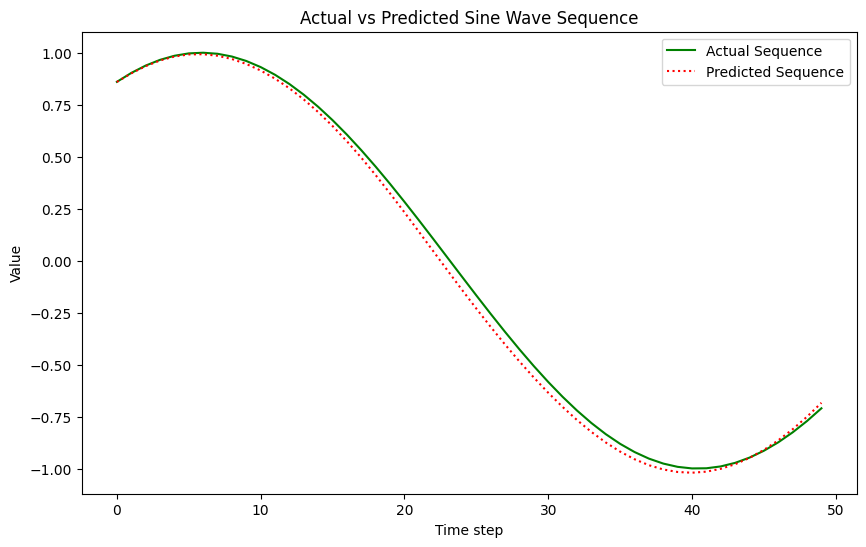

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Define the Encoder class
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)

    def forward(self, input_seq):
        output, (hidden, cell) = self.lstm(input_seq)
        return hidden, cell

# Step 2: Define the Decoder class
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(output_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden, cell):
        output, (hidden, cell) = self.lstm(input_seq, (hidden, cell))
        prediction = self.fc_out(output)
        return prediction, hidden, cell

# Step 3: Define the Seq2Seq model class with Teacher Forcing
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source_seq, target_seq_len, teacher_forcing_ratio=0.5):
        batch_size = source_seq.shape[1]
        output_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(target_seq_len, batch_size, output_size).to(source_seq.device)

        hidden, cell = self.encoder(source_seq)

        decoder_input = torch.zeros(1, batch_size, output_size).to(source_seq.device)

        for t in range(target_seq_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[t] = output
            use_teacher_forcing = np.random.random() < teacher_forcing_ratio
            decoder_input = output if not use_teacher_forcing else source_seq[t].unsqueeze(0)

        return outputs

# Step 4: Generate Sine Wave Data
def generate_sine_data(seq_len=50, n_samples=1000):
    X = np.linspace(0, 100, n_samples)
    y = np.sin(X)
    
    data = []
    for i in range(len(y) - seq_len):
        data.append(y[i:i+seq_len])

    data = np.array(data)
    data = data.reshape((data.shape[0], seq_len, 1))

    train_size = int(0.8 * data.shape[0])
    X_train = data[:train_size]
    X_test = data[train_size:]

    return torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(X_test, dtype=torch.float32).to(device)

# Step 5: Training the Seq2Seq model
def train_seq2seq(model, X_train, epochs=100, learning_rate=0.001, teacher_forcing_ratio=0.5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        optimizer.zero_grad()

        outputs = model(X_train.permute(1, 0, 2), X_train.shape[1], teacher_forcing_ratio)
        
        loss = criterion(outputs, X_train.permute(1, 0, 2))
        
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# Step 6: Evaluation with plotting
def evaluate_seq2seq(model, X_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test.permute(1, 0, 2), X_test.shape[1], teacher_forcing_ratio=0.0)
        predictions = predictions.permute(1, 0, 2).cpu().numpy()  # Convert to numpy for plotting
        X_test = X_test.cpu().numpy()  # Convert to numpy for plotting

        # Plot the actual and predicted sequences
        plt.figure(figsize=(10, 6))
        plt.plot(X_test[0], label="Actual Sequence", color='green')
        plt.plot(predictions[0], label="Predicted Sequence", linestyle=":", color='red')
        plt.title("Actual vs Predicted Sine Wave Sequence")
        plt.xlabel("Time step")
        plt.ylabel("Value")
        plt.legend()
        plt.show()

# Step 7: Putting it all together
if __name__ == "__main__":
    # Generate sine wave data
    X_train, X_test = generate_sine_data(seq_len=50, n_samples=1100)

    # Define the model parameters
    input_size = 1
    hidden_size = 64
    output_size = 1

    # Initialize Encoder, Decoder, and Seq2Seq model
    encoder = Encoder(input_size, hidden_size).to(device)
    decoder = Decoder(hidden_size, output_size).to(device)
    seq2seq_model = Seq2Seq(encoder, decoder).to(device)

    # Train the model
    train_seq2seq(seq2seq_model, X_train, epochs=200, learning_rate=0.001, teacher_forcing_ratio=0.5)

    # Evaluate and plot
    evaluate_seq2seq(seq2seq_model, X_test)
